# Data Pre-processing

### Extracting the data

In [105]:
!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
x cifar-100-python/
x cifar-100-python/file.txt~
x cifar-100-python/train
x cifar-100-python/test
x cifar-100-python/meta


### Load CIFAR10

In [106]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def unpickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

# CIFAR-10
meta10 = unpickle("cifar-10-batches-py/batches.meta")
cifar10_classes = [x.decode('utf-8') for x in meta10[b'label_names']]

print("CIFAR-10 classes:")
for i, name in enumerate(cifar10_classes):
    print(i, name)

CIFAR-10 classes:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


### Extract the ids we need for CIFAR-10

In [107]:
cifar10_needed_ids = [1, 2, 3, 4, 5, 7, 9] # automobile, bird, cat, deer, dog, horse, truck

X_train_10 = []
y_train_10 = []

for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_train_10.append(batch[b'data'])
    y_train_10.append(batch[b'labels'])

X_train_10 = np.concatenate(X_train_10)
y_train_10 = np.concatenate(y_train_10)

# filter only needed CIFAR-10 classes
train_mask_10 = np.isin(y_train_10, cifar10_needed_ids)
X_train_10_filtered = X_train_10[train_mask_10]
y_train_10_filtered = y_train_10[train_mask_10]

# filter CIFAR-10 test batch
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test_10 = test_batch[b'data']
y_test_10 = np.array(test_batch[b'labels'])

test_mask_10 = np.isin(y_test_10, cifar10_needed_ids)
X_test_10_filtered = X_test_10[test_mask_10]
y_test_10_filtered = y_test_10[test_mask_10]

print(X_train_10_filtered.shape, y_train_10_filtered.shape)
print(X_test_10_filtered.shape, y_test_10_filtered.shape)

(35000, 3072) (35000,)
(7000, 3072) (7000,)


The shape of these matrices make sense as <br>
X_train_10 filtered 50,000 training images and we only took 7 classes out of 10 so that is 35,000, and it has 32px x 32px x 3(RGB) = 3072. y_train_10 filtered is also 35000 <br>
X_test_filtered has 7000 rows which makes sense as we originally had 10000 but took only 7 classes out of 10

### Load CIFAR100

In [108]:
# CIFAR-100
meta100 = unpickle("cifar-100-python/meta")
train_100 = unpickle("cifar-100-python/train")
test_100 = unpickle("cifar-100-python/test")

cifar100_fine_classes = [x.decode('utf-8') for x in meta100[b'fine_label_names']]
cifar100_coarse_classes = [x.decode('utf-8') for x in meta100[b'coarse_label_names']]

trees_coarse_idx = cifar100_coarse_classes.index('trees')

# Checking if our ids are correct

# print("CIFAR-100 fine labels:")
# for i, name in enumerate(cifar100_fine_classes):
#     print(i, name)

# print("\nCIFAR-100 coarse labels:")
# for i, name in enumerate(cifar100_coarse_classes):
#     print(i, name)

cifar100_target_fine = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'tractor']

# cifar100_needed_ids = [i for i, name in enumerate(cifar100_fine_classes) if name in target_fine_classes]
# print("Selected fine IDs:", cifar100_needed_ids)


### Extract the ids we need for CIFAR-100

In [109]:
X_train_100 = train_100[b'data']
y_train_100_fine = np.array(train_100[b'fine_labels'])
y_train_100_coarse = np.array(train_100[b'coarse_labels'])

X_test_100 = test_100[b'data']
y_test_100_fine = np.array(test_100[b'fine_labels'])
y_test_100_coarse = np.array(test_100[b'coarse_labels'])

def select_and_map_cifar100(X, fine_labels, coarse_labels):
    kept_indices = []
    mapped_names = []
    for i, (f, c) in enumerate(zip(fine_labels, coarse_labels)):
        if c == trees_coarse_idx:
            kept_indices.append(i)
            mapped_names.append('trees')
        else:
            fine_name = cifar100_fine_classes[f]
            if fine_name in cifar100_target_fine:
                kept_indices.append(i)
                mapped_names.append(fine_name)
    X_filtered = X[kept_indices]
    return X_filtered, np.array(mapped_names)

X_train_100_filtered, y_train_100_names = select_and_map_cifar100(
    X_train_100, y_train_100_fine, y_train_100_coarse
)
X_test_100_filtered,  y_test_100_names  = select_and_map_cifar100(
    X_test_100,  y_test_100_fine,  y_test_100_coarse
)

print("CIFAR-100 selected train shape:", X_train_100_filtered.shape, "labels:", y_train_100_names.shape)
print("CIFAR-100 selected test  shape:", X_test_100_filtered.shape,  "labels:", y_test_100_names.shape)

CIFAR-100 selected train shape: (10500, 3072) labels: (10500,)
CIFAR-100 selected test  shape: (2100, 3072) labels: (2100,)


Same here for CIFAR-100, we had 50,000 images but took 17 classes so 8500 images (50000 * 0.7)<br>
The test data had 10,000 but we took 17 so now 1700

### Remapping Label as ID to avoid collision

In [110]:
cifar10_selected_names = [cifar10_classes[i] for i in cifar10_needed_ids]

y_train_10_names = [cifar10_classes[i] for i in y_train_10_filtered]
y_test_10_names  = [cifar10_classes[i] for i in y_test_10_filtered]

cifar100_selected_names_ordered = list(dict.fromkeys(list(y_train_100_names) + list(y_test_100_names)))

cifar100_selected_names_explicit = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'tractor', 'trees']

all_class_names = list(dict.fromkeys(cifar10_selected_names + cifar100_selected_names_explicit))

label_map = {name: idx for idx, name in enumerate(all_class_names)}

print("Unified class count:", len(label_map))
print("Label map:", label_map)

y_train_10_new = np.array([label_map[name] for name in y_train_10_names])
y_test_10_new  = np.array([label_map[name] for name in y_test_10_names])

y_train_100_new = np.array([label_map[name] for name in y_train_100_names])
y_test_100_new  = np.array([label_map[name] for name in y_test_100_names])

y_train_10_filtered  = y_train_10_new
y_test_10_filtered   = y_test_10_new
y_train_100_filtered = y_train_100_new
y_test_100_filtered  = y_test_100_new

X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered], axis=0)
y_train_combined = np.concatenate([y_train_10_filtered, y_train_100_filtered], axis=0)
X_test_combined  = np.concatenate([X_test_10_filtered,  X_test_100_filtered],  axis=0)
y_test_combined  = np.concatenate([y_test_10_filtered,  y_test_100_filtered],  axis=0)

print("Combined train shape:", X_train_combined.shape, y_train_combined.shape)
print("Combined test shape:",  X_test_combined.shape,  y_test_combined.shape)

print("Unique training labels:", np.unique(y_train_combined))
print("Unique test labels: ", np.unique(y_test_combined))

Unified class count: 24
Label map: {'automobile': 0, 'bird': 1, 'cat': 2, 'deer': 3, 'dog': 4, 'horse': 5, 'truck': 6, 'cattle': 7, 'fox': 8, 'baby': 9, 'boy': 10, 'girl': 11, 'man': 12, 'woman': 13, 'rabbit': 14, 'squirrel': 15, 'bicycle': 16, 'bus': 17, 'motorcycle': 18, 'pickup_truck': 19, 'train': 20, 'lawn_mower': 21, 'tractor': 22, 'trees': 23}
Combined train shape: (45500, 3072) (45500,)
Combined test shape: (9100, 3072) (9100,)
Unique training labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


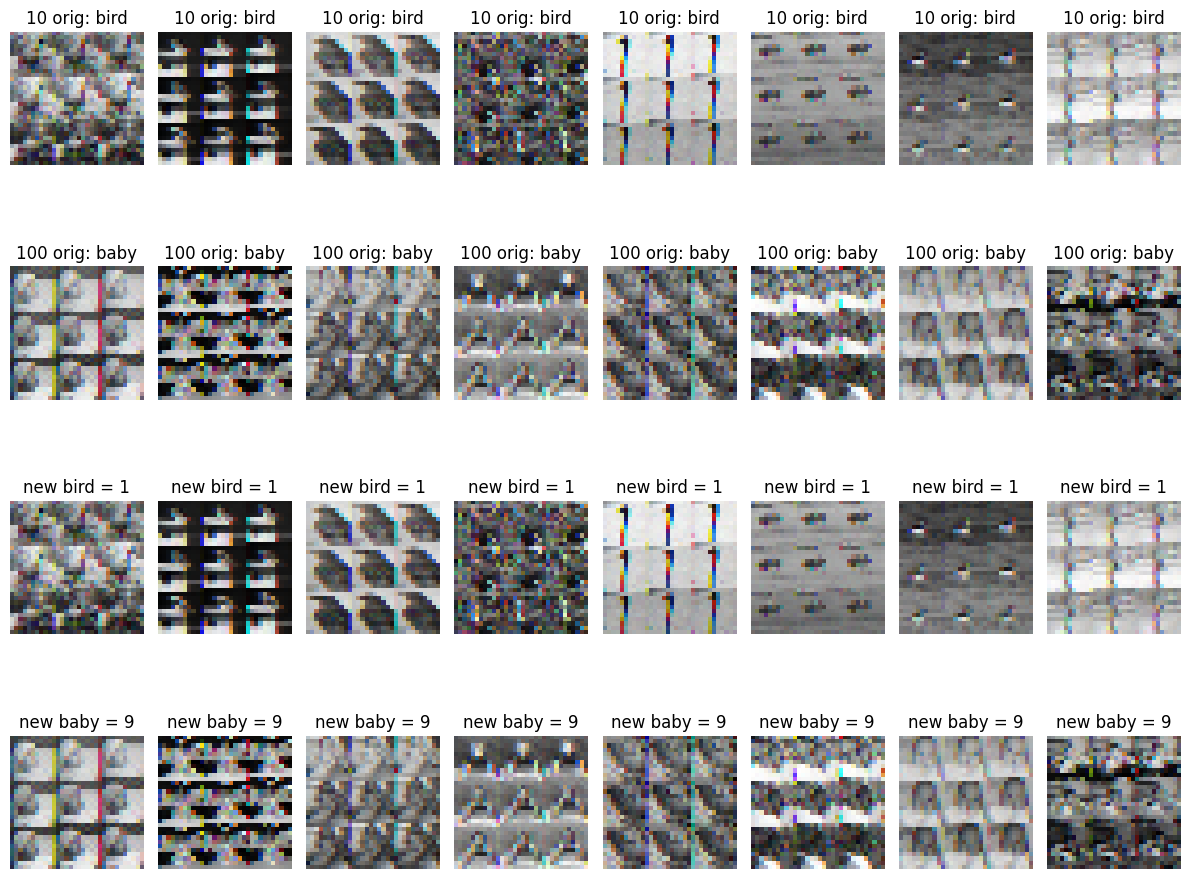

CIFAR-10 'bird' old label 2 -> new label = 1
CIFAR-100 'baby' old label 2 -> new label = 9


In [111]:
orig_class_10 = "bird"
orig_class_100 = "baby"

orig_label_10 = cifar10_classes.index(orig_class_10)
orig_label_100 = cifar100_fine_classes.index(orig_class_100)

# original samples
indices_10_orig = np.where(y_train_10 == orig_label_10)[0][:8]
indices_100_orig = np.where(y_train_100 == orig_label_100)[0][:8]

# new mapped labels
new_label_10 = label_map[orig_class_10]
new_label_100 = label_map[orig_class_100]

indices_10_new = np.where(y_train_10_filtered == new_label_10)[0][:8]
indices_100_new = np.where(y_train_100_filtered == new_label_100)[0][:8]

plt.figure(figsize=(12, 10))

# CIFAR-10 original
for i, idx in enumerate(indices_10_orig):
    img = X_train_10[idx].reshape(32,32,3)
    plt.subplot(4, 8, i+1)
    plt.imshow(img)
    plt.title("10 orig: bird")
    plt.axis("off")

# CIFAR-100 original
for i, idx in enumerate(indices_100_orig):
    img = X_train_100[idx].reshape(32,32,3)
    plt.subplot(4, 8, i+1+8)
    plt.imshow(img)
    plt.title("100 orig: baby")
    plt.axis("off")

# CIFAR-10 new label
for i, idx in enumerate(indices_10_new):
    img = X_train_10_filtered[idx].reshape(32,32,3)
    plt.subplot(4, 8, i+1+16)
    plt.imshow(img)
    plt.title(f"new bird = {new_label_10}")
    plt.axis("off")

# CIFAR-100 new label
for i, idx in enumerate(indices_100_new):
    img = X_train_100_filtered[idx].reshape(32,32,3)
    plt.subplot(4, 8, i+1+24)
    plt.imshow(img)
    plt.title(f"new baby = {new_label_100}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print(f"CIFAR-10 'bird' old label 2 -> new label = {new_label_10}")
print(f"CIFAR-100 'baby' old label 2 -> new label = {new_label_100}")


### Combine CIFAR-10 and CIFAR-100 and save files

In [112]:
X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered])
y_train_combined = np.concatenate([y_train_10_filtered, y_train_100_filtered])

X_test_combined = np.concatenate([X_test_10_filtered, X_test_100_filtered])
y_test_combined = np.concatenate([y_test_10_filtered, y_test_100_filtered])

print(X_train_combined.shape, y_train_combined.shape)
print(X_test_combined.shape, y_test_combined.shape)

os.makedirs('combined', exist_ok=True)

train_data = {'features': X_train_combined, 'labels': y_train_combined}
test_data  = {'features': X_test_combined, 'labels': y_test_combined}

# 0.1 for 10% of training split
val_split = int(0.1 * X_train_combined.shape[0])
val_data = {'features': X_train_combined[:val_split], 'labels': y_train_combined[:val_split]}
train_data = {'features': X_train_combined[val_split:], 'labels': y_train_combined[val_split:]}

with open('combined/train.p', 'wb') as f:
    pickle.dump(train_data, f)
with open('combined/valid.p', 'wb') as f:
    pickle.dump(val_data, f)
with open('combined/test.p', 'wb') as f:
    pickle.dump(test_data, f)

(45500, 3072) (45500,)
(9100, 3072) (9100,)


Now we are reading in the train_data, val_data and test_data that we just created and checking the shape

In [113]:
with open('combined/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('combined/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('combined/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(40950, 3072) (4550, 3072) (9100, 3072)
(40950,) (4550,) (9100,)


We need to reshape it to the correct size to be able to apply pre-processing to it

In [115]:
X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print(X_train.shape, X_val.shape, X_test.shape)

(40950, 32, 32, 3) (4550, 32, 32, 3) (9100, 32, 32, 3)


### Data Pre-processing

In [116]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def equalize(img):
    return cv2.equalizeHist(img)

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255.0
    return img


### Displaying each

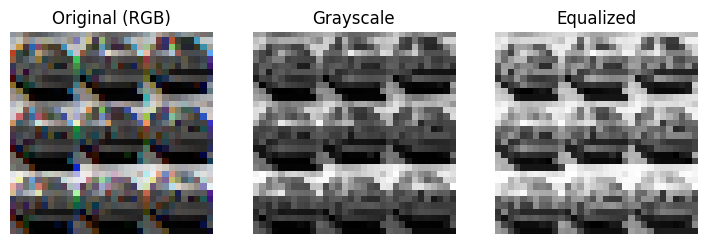

In [18]:
random_index = 555
img_original = X_train[random_index]

img_gray = grayscale(img_original)
img_equalized = equalize(img_gray)
img_normalized = img_equalized / 255.0

plt.figure(figsize=(12, 3))

# our orignial image
plt.subplot(1, 4, 1)
plt.imshow(img_original)
plt.title("Original (RGB)")
plt.axis("off")

# grayscale
plt.subplot(1, 4, 2)
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

# equalized
plt.subplot(1, 4, 3)
plt.imshow(img_equalized, cmap='gray')
plt.title("Equalized")
plt.axis("off")

plt.show()

### Reshaping

In [19]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# Data Exploration

In [20]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (40950, 32, 32, 1) (40950,)
Validation set shape: (4550, 32, 32, 1) (4550,)
Test set shape: (9100, 32, 32, 1) (9100,)


In [21]:
print("Unique CIFAR-10 labels:", np.unique(y_train_10_filtered))
print("Unique CIFAR-100 labels:", np.unique(y_train_100_filtered))
print("Combined:", np.unique(y_train_combined))


Unique CIFAR-10 labels: [0 1 2 3 4 5 6]
Unique CIFAR-100 labels: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Combined: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


Number of classes: 28


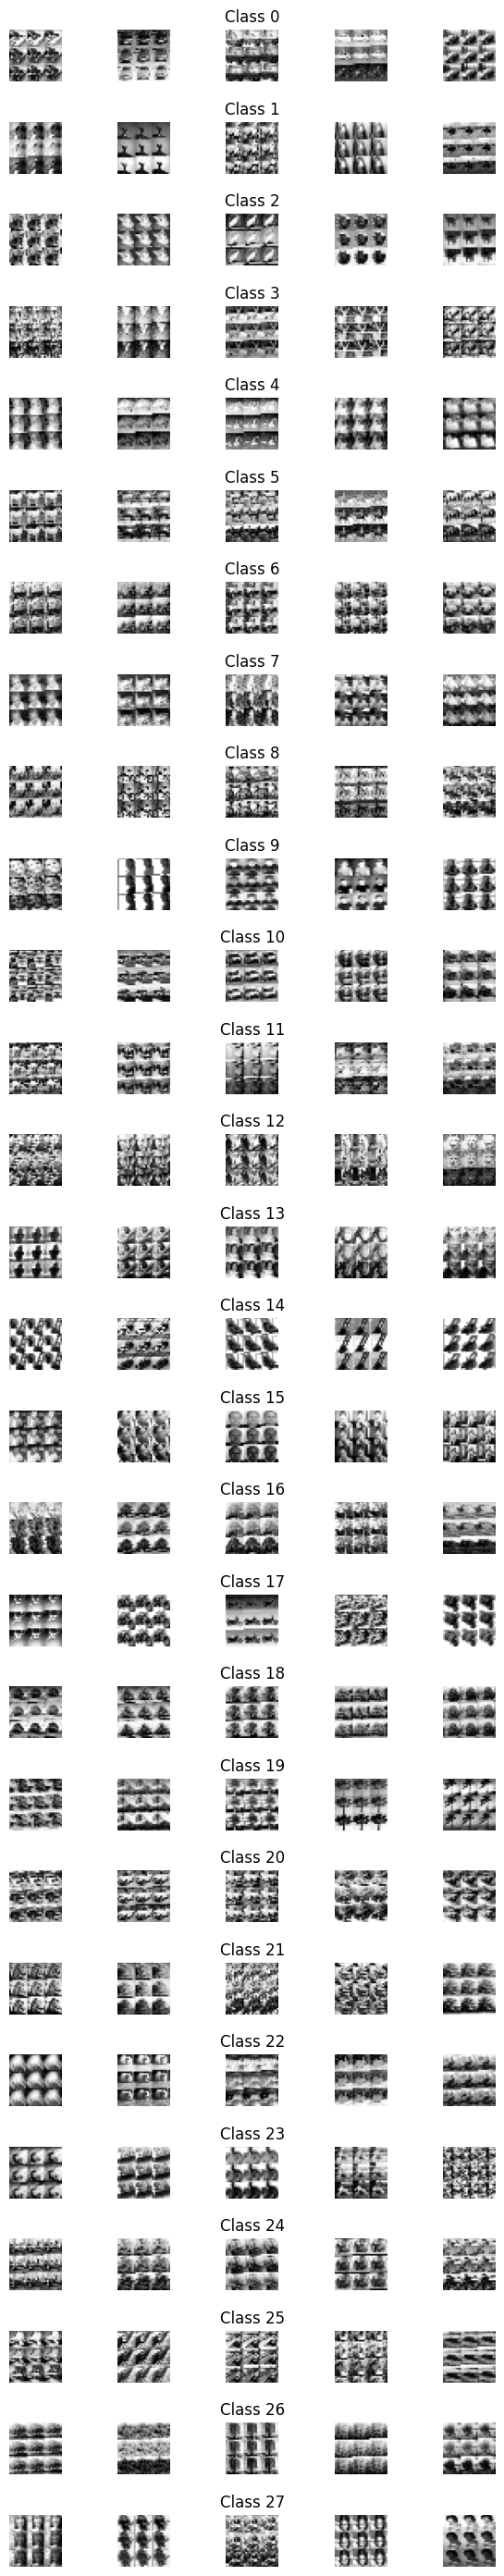

In [22]:
num_of_samples = []
cols = 5
classes = np.unique(y_train)
num_classes = len(classes)
print("Number of classes:", num_classes)

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(6, num_classes))
fig.tight_layout(pad=1)

for class_id_idx, class_id in enumerate(classes):
    x_selected = X_train[y_train == class_id]

    num_of_samples.append(len(x_selected))

    for col in range(cols):
        axs[class_id_idx][col].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :, 0], cmap='gray')
        axs[class_id_idx][col].axis("off")

        if col == cols // 2:
            axs[class_id_idx][col].set_title(f"Class {class_id}")

plt.show()


[4397, 4326, 4360, 4323, 4363, 4351, 4330, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


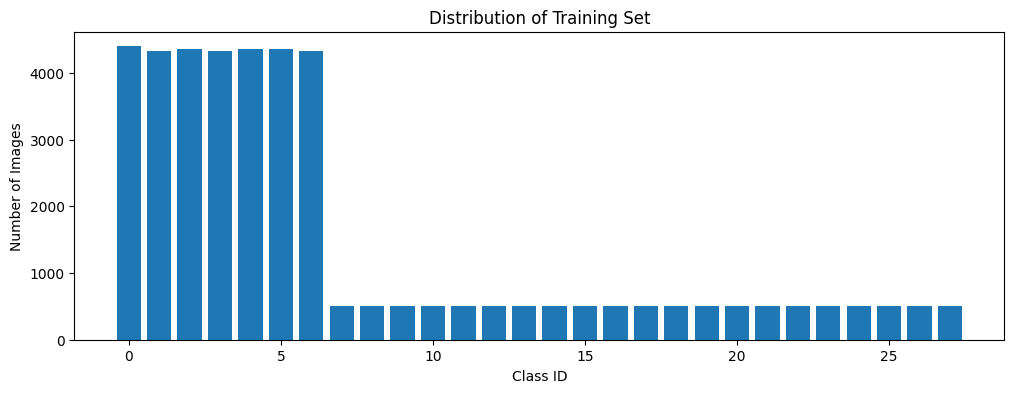

In [23]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(classes, num_of_samples)
plt.title("Distribution of Training Set")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

### What size are the images and what classes do the images represent?

The images were size 32, 32, 3 which represents 32 pixels x 32 pixels x RGB
After preprocessing (grayscale, equalisation and normalisation) they became 32, 32, 1 since they are no longer in colour.
The classes represent the 7 classes selected for CIFAR10 and 21 classes selected from CIFAR100, making 28 classes total.

### Comment on relative numbers of each type of image

Having observed the distribution of Training Set of both CIFAR 10 and CIFAR 100 above, we can clearly see a huge differene in the number of images between CIFAR 10 and CIFAR 100.

The output of the number of samples is this: [4397, 4326, 4360, 4323, 4363, 4351, 4330, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

The first 7 classes are from CIFAR10, around 4300, and the rest with 500 each are from CIFAR100. This imbalance can bias the model towards classes with more samples leading to higher accuracy for CIFAR10 classes but lower accuracy for CIFAR100 classes.

There are a few ways that we could address this class imbalance:
 - Data Augmentation to increase the number of images in the CIFAR100 classes to balance the training set by use of flips, noise, cropping, brightness, etc
 - Oversampling for the CIFAR100 images by duplicating them to increase their size and balance the training set
 - Class weights during training, address class imbalance by assigning a higher importance to CIFAR100 classes

We have decided to perform Data Augmentation during Model Building to address class imbalance.

### Data Augmentation Demonstration (John's)

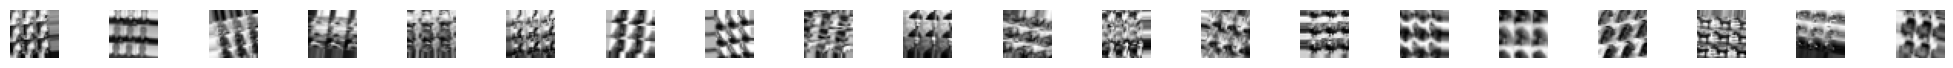

In [77]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range=10)
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 20, figsize=(20, 5))
fig.tight_layout()
for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
  axs[i].axis('off')

### Data Augmentation

In [79]:
TARGET_COUNT = 4300

X_train_balanced = []
y_train_balanced = []

classes = np.unique(y_train)

for c in classes:
    idx = np.where(y_train == c)[0]
    X_c = X_train[idx]
    y_c = y_train[idx]

    if len(X_c) >= TARGET_COUNT:
        X_train_balanced.append(X_c)
        y_train_balanced.append(y_c)
        continue

    needed = TARGET_COUNT - len(X_c)
    print(f"Class {c}: generating {needed} augmented images...")

    gen = datagen.flow(X_c, y_c, batch_size=32, shuffle=True)

    X_aug = []
    y_aug = []

    while len(X_aug) < needed:
        X_batch, y_batch = next(gen)
        X_aug.append(X_batch)
        y_aug.append(y_batch)

    X_aug = np.concatenate(X_aug)[:needed]
    y_aug = np.concatenate(y_aug)[:needed]

    X_train_balanced.append(np.concatenate([X_c, X_aug]))
    y_train_balanced.append(np.concatenate([y_c, y_aug]))

X_train = np.concatenate(X_train_balanced)
y_train = np.concatenate(y_train_balanced)

print("New training set:", X_train.shape, y_train.shape)


New training set: (120750, 32, 32, 1) (120750,)


In [80]:
save_path = "combined"
os.makedirs(save_path, exist_ok=True)

train_balanced_data = {
    "features": X_train,
    "labels": y_train
}

with open(os.path.join(save_path, "train_balanced.p"), "wb") as f:
    pickle.dump(train_balanced_data, f)

print("Saved to:", os.path.join(save_path, "train_balanced.p"))
print("Saved shape:", X_train.shape, y_train.shape)

Saved to: combined\train_balanced.p
Saved shape: (120750, 32, 32, 1) (120750,)


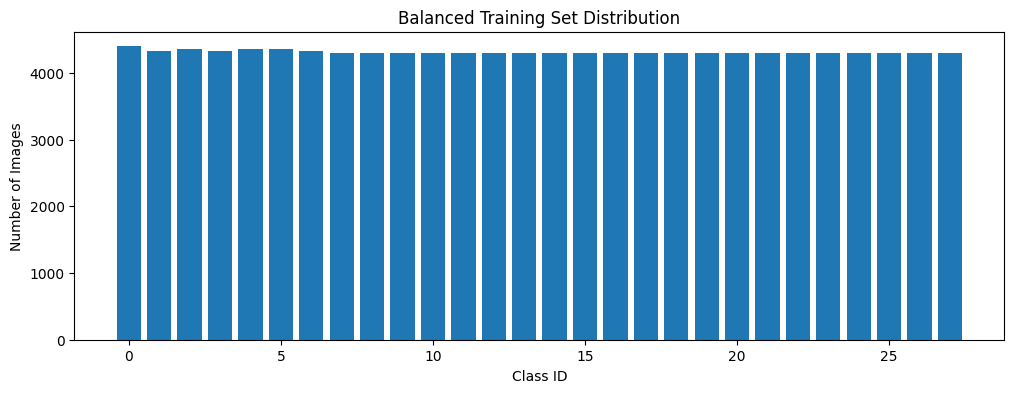

[4397, 4326, 4360, 4323, 4363, 4351, 4330, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300, 4300]


In [ ]:
classes = np.unique(y_train)
num_samples_new = [len(np.where(y_train == c)[0]) for c in classes]

plt.figure(figsize=(12, 4))
plt.bar(classes, num_samples_new)
plt.title("Balanced Training Set Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

print(num_samples_new)


# Model Training

In [81]:
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32,32,1),  activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = leNet_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │       540,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │        14,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,318 (2.18 MB)

 Trainable params: 572,318 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - accuracy: 0.2152 - loss: 2.5642 - val_accuracy: 0.4387 - val_loss: 1.7634
Epoch 2/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 66s 27ms/step - accuracy: 0.2861 - loss: 2.2869 - val_accuracy: 0.5073 - val_loss: 1.5575
Epoch 3/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.3117 - loss: 2.1971 - val_accuracy: 0.5202 - val_loss: 1.4842
Epoch 4/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 66s 27ms/step - accuracy: 0.3285 - loss: 2.1387 - val_accuracy: 0.5240 - val_loss: 1.5185
Epoch 5/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.3433 - loss: 2.0948 - val_accuracy: 0.5097 - val_loss: 1.6109
Epoch 6/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.3547 - loss: 2.0482 - val_accuracy: 0.4782 - val_loss: 1.7292
Epoch 7/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - accuracy: 0.3650 - loss: 2.0121 - val_accuracy: 0.5248 - val_loss: 1.5440
Epoch 8/15
2415/2415 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.3738 -

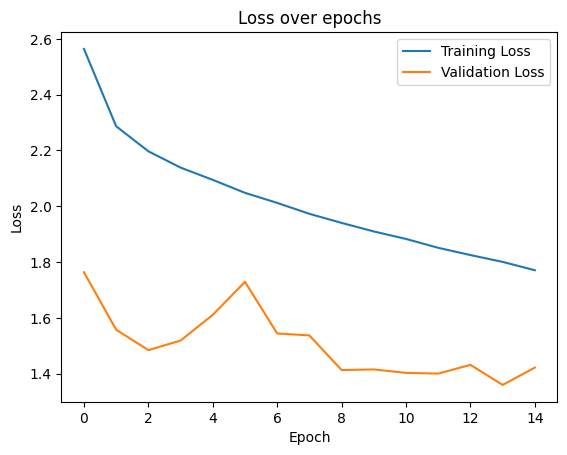

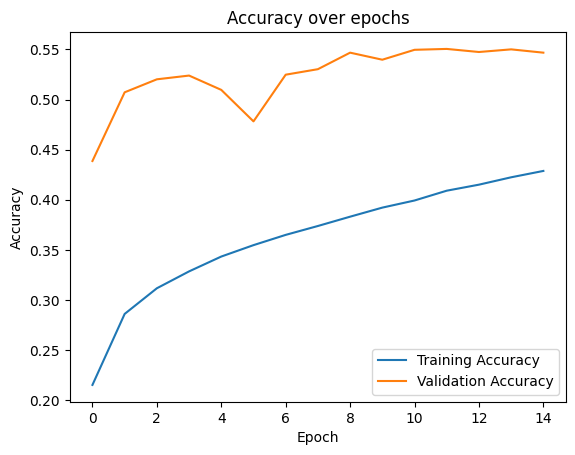

285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4563 - loss: 1.8017
Test Loss: 1.8017
Test Accuracy: 0.4563


In [82]:
batch_size = 50
epochs = 15

history = model.fit(
    X_train, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    shuffle=True,
    verbose=1
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

score = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")